In [1]:
# @title Bước 1: Mount Google Drive và Import Thư viện

# Mount Google Drive để truy cập dữ liệu
from google.colab import drive
drive.mount('/content/drive')

# Import các thư viện cần thiết
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
import time
import zipfile
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Mounted at /content/drive


In [2]:
# @title Bước 2: Giải nén tệp dữ liệu từ Google Drive

# Cập nhật đường dẫn tới tệp zip trên Google Drive của bạn
# Hãy thay đổi 'My Drive/archive.zip' cho phù hợp với vị trí tệp của bạn.
zip_file_path = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/Dataset/archive.zip'
extract_dir = 'chest_xray_data'

# Kiểm tra xem tệp zip có tồn tại không
if not os.path.exists(zip_file_path):
    print(f"Lỗi: Không tìm thấy tệp tại '{zip_file_path}'.")
    print("Vui lòng kiểm tra lại đường dẫn và đảm bảo bạn đã tải tệp 'archive.zip' lên Google Drive.")
else:
    # Tạo thư mục nếu nó chưa tồn tại và tiến hành giải nén
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_dir)
        print(f"Đã giải nén tệp '{os.path.basename(zip_file_path)}' vào thư mục '{extract_dir}'.")
    else:
        print(f"Thư mục '{extract_dir}' đã tồn tại, bỏ qua bước giải nén.")

Đã giải nén tệp 'archive.zip' vào thư mục 'chest_xray_data'.


In [3]:
# @title Bước 3: Thiết lập cấu hình và đường dẫn

# Các tham số cho mô hình và dữ liệu
IMG_WIDTH, IMG_HEIGHT = 150, 150
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 0.001

# Đường dẫn tới các tập dữ liệu sau khi giải nén
# Cấu trúc phổ biến: chest_xray_data/chest_xray/train, test, val
base_data_dir = os.path.join(extract_dir, 'chest_xray')

train_dir = os.path.join(base_data_dir, 'train')
validation_dir = os.path.join(base_data_dir, 'val')
test_dir = os.path.join(base_data_dir, 'test')

# Kiểm tra xem các đường dẫn có tồn tại không
if not os.path.exists(train_dir) or not os.path.exists(validation_dir) or not os.path.exists(test_dir):
    print(f"Lỗi: Không tìm thấy một hoặc nhiều thư mục con (train, val, test) trong '{base_data_dir}'.")
    print("Vui lòng kiểm tra lại cấu trúc thư mục sau khi giải nén.")
else:
    print("Các đường dẫn dữ liệu đã được xác nhận thành công.")

Các đường dẫn dữ liệu đã được xác nhận thành công.


In [4]:
# @title Bước 4: Chuẩn bị và Tăng cường dữ liệu

# Tạo trình tăng cường dữ liệu cho tập huấn luyện
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Chỉ rescale cho tập validation và test
validation_test_datagen = ImageDataGenerator(rescale=1./255)

# Tạo các trình tạo dữ liệu (Data Generators) từ thư mục
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb'
)

validation_generator = validation_test_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

test_generator = validation_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

# In ra các lớp đã được gán nhãn
print("Các lớp được tìm thấy:", train_generator.class_indices)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Các lớp được tìm thấy: {'NORMAL': 0, 'PNEUMONIA': 1}


/tmp/ipython-input-935110268.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=axes[i], palette=custom_palette)
/tmp/ipython-input-935110268.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=axes[i], palette=custom_palette)
/tmp/ipython-input-935110268.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=axes[i], palette=custom_palette)


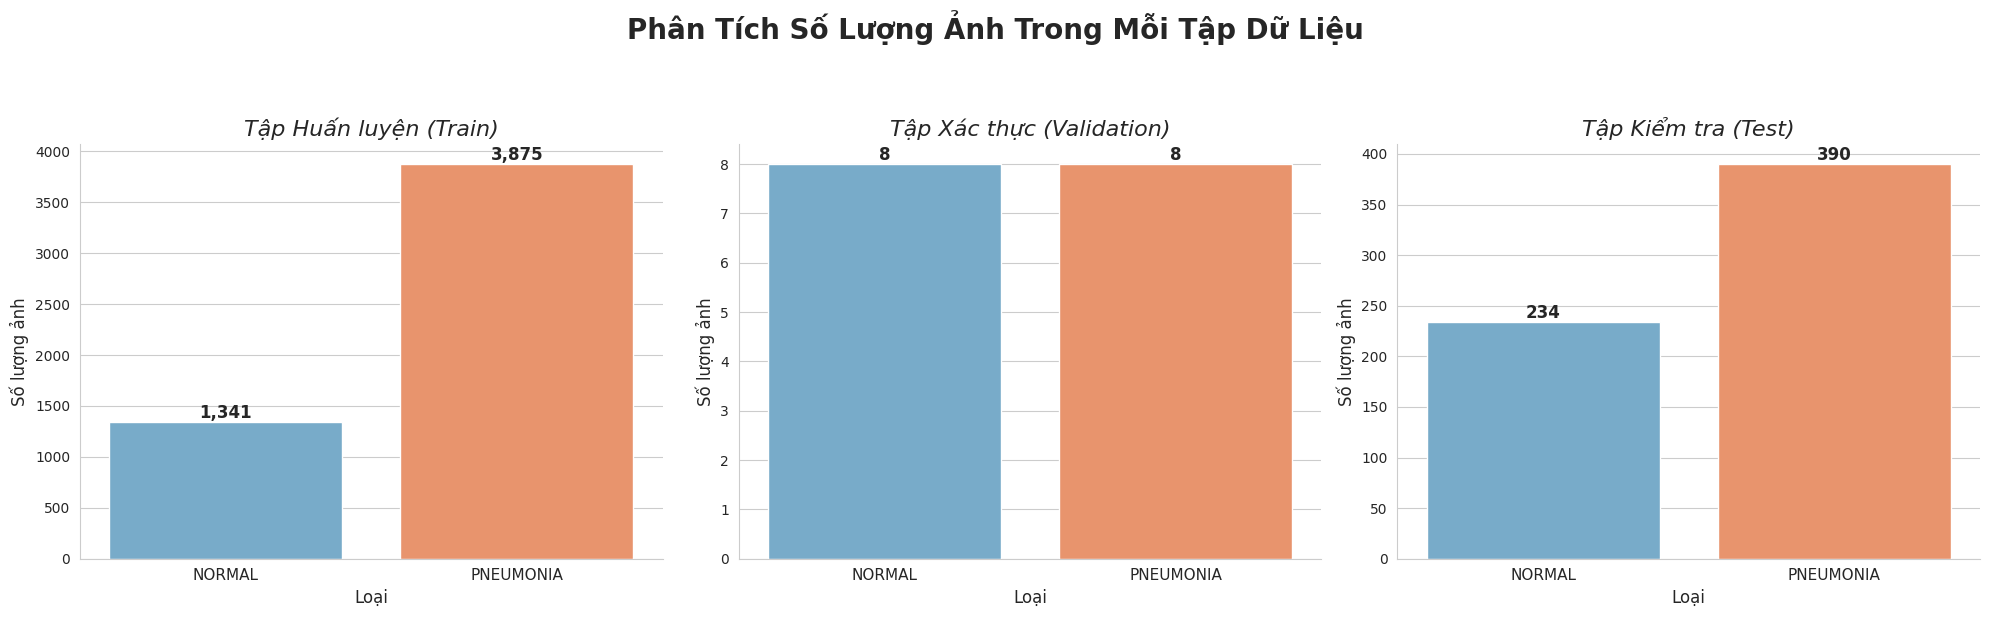

In [5]:
# @title Bước 4.1: Trực quan hóa Sự phân bổ dữ liệu

import matplotlib.pyplot as plt
import seaborn as sns

def plot_data_distribution_redesigned(data_dirs, set_names):
    """Vẽ biểu đồ cột thể hiện sự phân bổ của các lớp với thiết kế cải tiến."""

    # Thiết lập phong cách cho biểu đồ
    sns.set_style("whitegrid")

    # Tạo bảng màu tùy chỉnh để dễ phân biệt
    custom_palette = {"NORMAL": "#6baed6", "PNEUMONIA": "#fc8d59"}

    fig, axes = plt.subplots(1, len(data_dirs), figsize=(20, 6))
    fig.suptitle('Phân Tích Số Lượng Ảnh Trong Mỗi Tập Dữ Liệu', fontsize=20, weight='bold', y=1.02)

    for i, data_dir in enumerate(data_dirs):
        normal_count = len(os.listdir(os.path.join(data_dir, 'NORMAL')))
        pneumonia_count = len(os.listdir(os.path.join(data_dir, 'PNEUMONIA')))
        counts = {'NORMAL': normal_count, 'PNEUMONIA': pneumonia_count}

        # Vẽ biểu đồ cột với bảng màu tùy chỉnh
        sns.barplot(x=list(counts.keys()), y=list(counts.values()), ax=axes[i], palette=custom_palette)

        # Cải thiện tiêu đề và nhãn
        axes[i].set_title(f'Tập {set_names[i]}', fontsize=16, style='italic')
        axes[i].set_ylabel('Số lượng ảnh', fontsize=12)
        axes[i].set_xlabel('Loại', fontsize=12)
        axes[i].tick_params(axis='x', labelsize=11)

        # Thêm số lượng lên trên mỗi cột với định dạng tốt hơn
        for index, value in enumerate(counts.values()):
            axes[i].text(index, value, f'{value:,}', ha='center', va='bottom', fontsize=12, weight='bold')

        # Xóa các đường viền không cần thiết
        sns.despine(ax=axes[i])

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Gọi hàm để vẽ đồ thị
plot_data_distribution_redesigned([train_dir, validation_dir, test_dir], ['Huấn luyện (Train)', 'Xác thực (Validation)', 'Kiểm tra (Test)'])

Các ảnh mẫu từ tập Huấn luyện (Train):


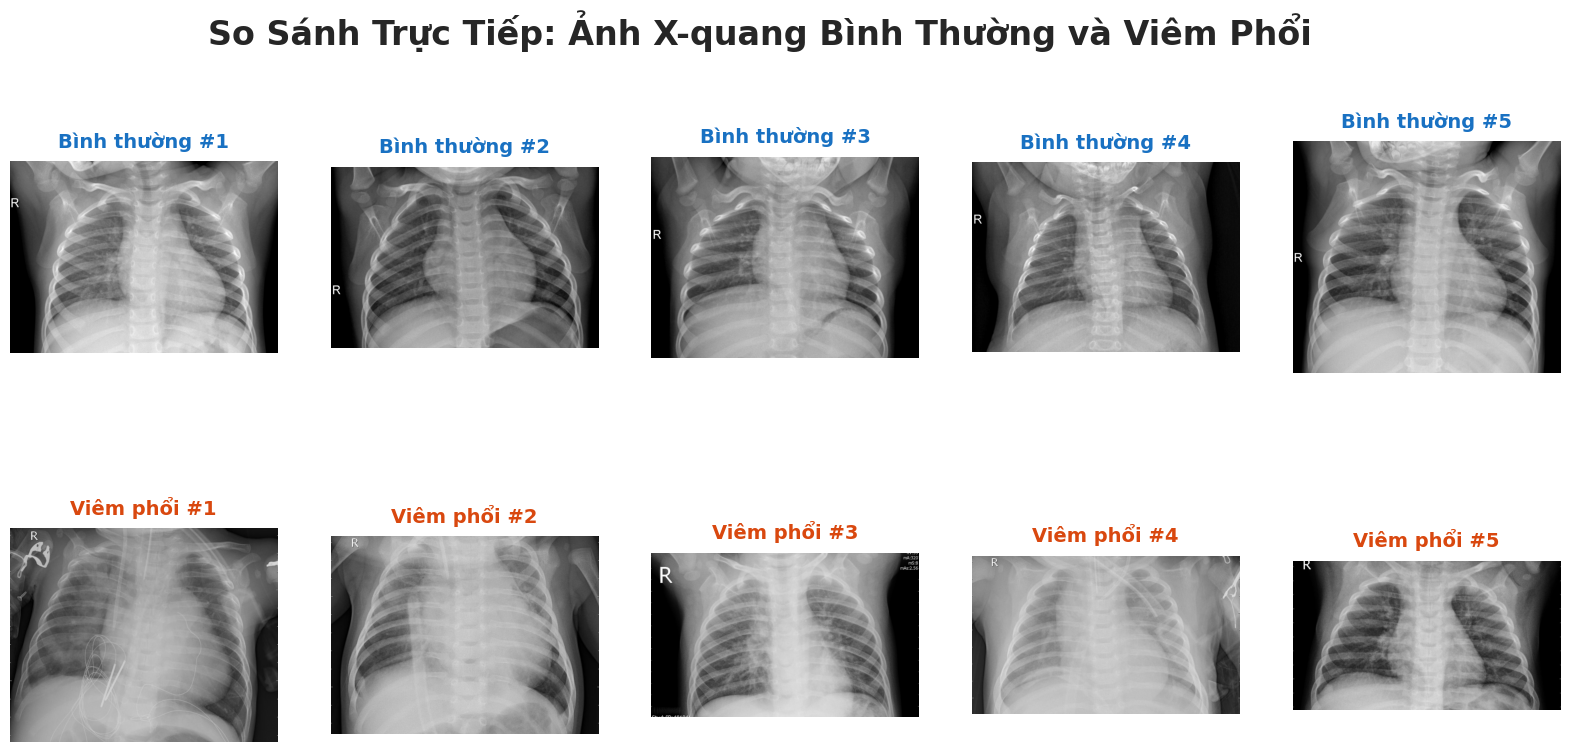

In [6]:
# @title Bước 4.2: Hiển thị ảnh mẫu (Bố cục Lưới So sánh Rõ ràng)

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_sample_images_uniform_grid(base_dir, num_samples=5):
    """Hiển thị ảnh mẫu trong một bố cục lưới đồng đều và rõ ràng."""

    # Thiết lập phong cách nền trắng để tập trung vào ảnh
    sns.set_style("white")

    # Tạo một lưới subplot. `figsize` được điều chỉnh để có không gian cho tiêu đề.
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 9))

    # Thêm một tiêu đề chính cho toàn bộ hình
    fig.suptitle(
        'So Sánh Trực Tiếp: Ảnh X-quang Bình Thường và Viêm Phổi',
        fontsize=24,
        fontweight='bold',
        y=0.98 # Điều chỉnh vị trí của tiêu đề chính
    )

    # Lấy đường dẫn và file ảnh
    normal_dir = os.path.join(base_dir, 'NORMAL')
    pneumonia_dir = os.path.join(base_dir, 'PNEUMONIA')
    normal_images = [os.path.join(normal_dir, fname) for fname in os.listdir(normal_dir)[:num_samples]]
    pneumonia_images = [os.path.join(pneumonia_dir, fname) for fname in os.listdir(pneumonia_dir)[:num_samples]]

    # Định nghĩa màu sắc cho tiêu đề để dễ phân biệt
    NORMAL_COLOR = '#1971c2'    # Màu xanh dương
    PNEUMONIA_COLOR = '#d9480f' # Màu cam/đỏ

    # Lặp qua từng cột để hiển thị ảnh
    for i in range(num_samples):
        # --- Hàng trên: Ảnh Bình thường (NORMAL) ---
        ax_normal = axes[0, i]
        img_normal = mpimg.imread(normal_images[i])
        ax_normal.imshow(img_normal, cmap='gray')
        # Đặt tiêu đề rõ ràng, được đánh số và có màu riêng cho từng ảnh
        ax_normal.set_title(f'Bình thường #{i+1}', color=NORMAL_COLOR, fontsize=14, weight='bold', pad=10)
        ax_normal.axis('off') # Tắt các trục tọa độ

        # --- Hàng dưới: Ảnh Viêm phổi (PNEUMONIA) ---
        ax_pneumonia = axes[1, i]
        img_pneumonia = mpimg.imread(pneumonia_images[i])
        ax_pneumonia.imshow(img_pneumonia, cmap='gray')
        # Đặt tiêu đề rõ ràng, được đánh số và có màu riêng cho từng ảnh
        ax_pneumonia.set_title(f'Viêm phổi #{i+1}', color=PNEUMONIA_COLOR, fontsize=14, weight='bold', pad=10)
        ax_pneumonia.axis('off')

    # Sử dụng tight_layout để tự động điều chỉnh khoảng cách giữa các subplot
    # rect=[0, 0, 1, 0.93] để tạo khoảng trống cho tiêu đề chính (suptitle)
    plt.show()

# Gọi hàm để hiển thị
print("Các ảnh mẫu từ tập Huấn luyện (Train):")
show_sample_images_uniform_grid(train_dir)

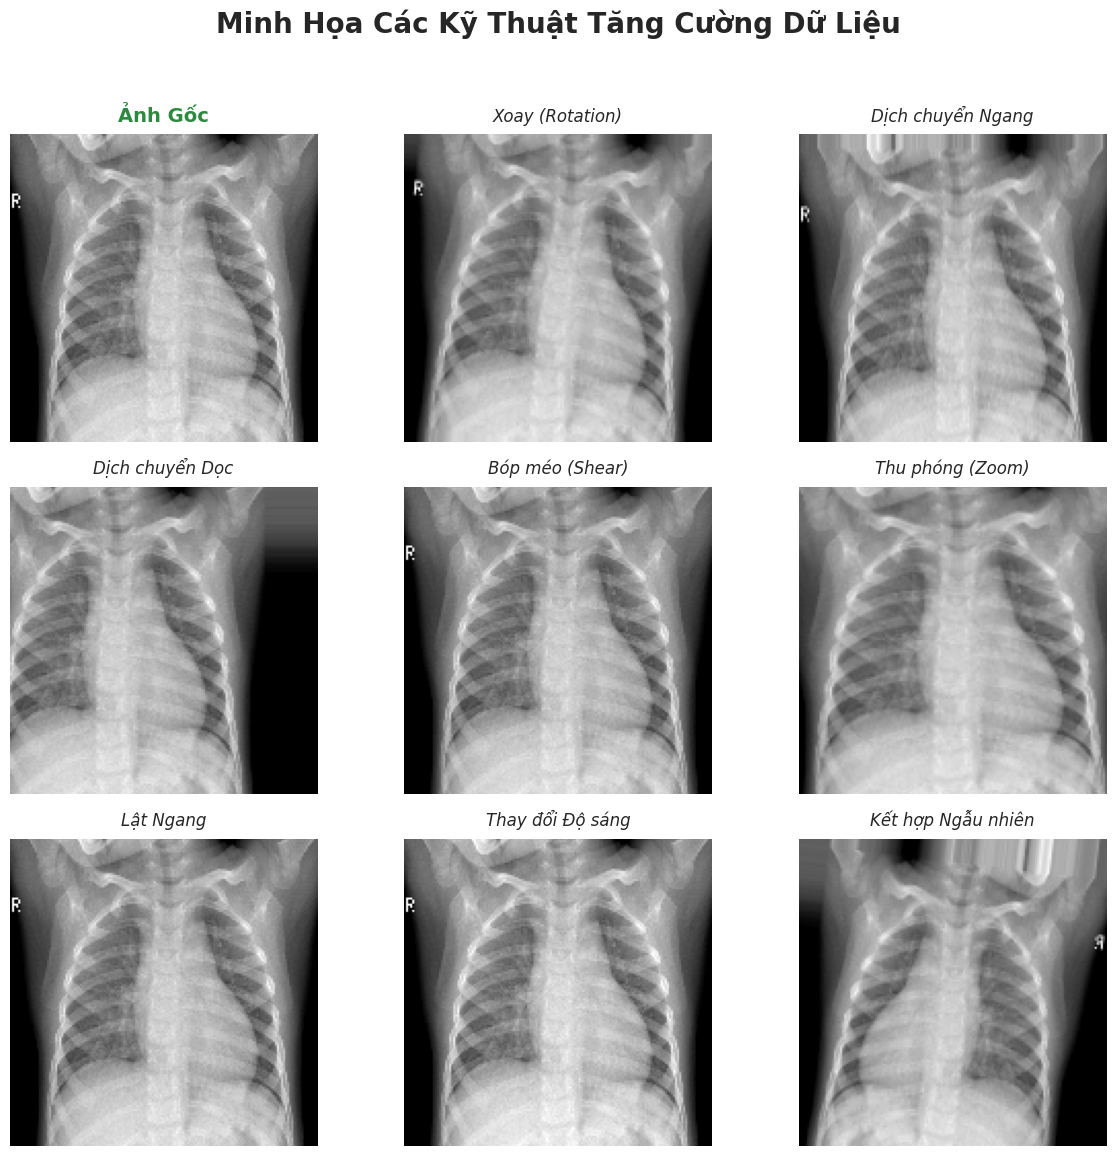

In [7]:
# @title Bước 4.3: Minh họa từng phép biến đổi (Ảnh kích thước nhỏ hơn)

from tensorflow.keras.preprocessing import image
import numpy as np

def visualize_specific_augmentations_compact(base_dir):
    """Minh họa tác dụng của từng phép biến đổi với kích thước ảnh nhỏ hơn."""

    # Thiết lập phong cách nền trắng
    sns.set_style("white")

    # 1. Chuẩn bị ảnh gốc
    sample_dir = os.path.join(base_dir, 'NORMAL')
    sample_image_path = os.path.join(sample_dir, os.listdir(sample_dir)[0])

    img = image.load_img(sample_image_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)

    # 2. Tạo các trình tăng cường dữ liệu riêng biệt
    augmentations = {
        'Xoay (Rotation)': ImageDataGenerator(rotation_range=30),
        'Dịch chuyển Ngang': ImageDataGenerator(width_shift_range=0.2),
        'Dịch chuyển Dọc': ImageDataGenerator(height_shift_range=0.2),
        'Bóp méo (Shear)': ImageDataGenerator(shear_range=0.2),
        'Thu phóng (Zoom)': ImageDataGenerator(zoom_range=[0.8, 1.2]),
        'Lật Ngang': ImageDataGenerator(horizontal_flip=True),
        'Thay đổi Độ sáng': ImageDataGenerator(brightness_range=[0.5, 1.5]),
        'Kết hợp Ngẫu nhiên': ImageDataGenerator(
            rotation_range=20, width_shift_range=0.1, horizontal_flip=True, zoom_range=0.1)
    }

    # 3. Vẽ đồ thị với figsize nhỏ hơn
    # <<< THAY ĐỔI CHÍNH Ở ĐÂY: Giảm figsize từ (18, 18) xuống (12, 12) >>>
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    fig.suptitle("Minh Họa Các Kỹ Thuật Tăng Cường Dữ Liệu", fontsize=20, fontweight='bold', y=0.96)

    axes_flat = axes.flatten()

    # --- Vẽ Ảnh Gốc ---
    ax_orig = axes_flat[0]
    ax_orig.imshow(img)
    # Tinh chỉnh lại cỡ chữ cho phù hợp
    ax_orig.set_title("Ảnh Gốc", fontsize=14, weight='bold', color='#2b8a3e', pad=10)
    ax_orig.axis('off')

    # --- Vẽ các ảnh đã được biến đổi ---
    for i, (name, datagen) in enumerate(augmentations.items()):
        ax = axes_flat[i + 1]

        aug_iterator = datagen.flow(img_batch, batch_size=1)
        augmented_img_batch = next(aug_iterator)
        augmented_img = augmented_img_batch[0].astype('uint8')

        ax.imshow(augmented_img)
        # Tinh chỉnh lại cỡ chữ cho phù hợp
        ax.set_title(name, fontsize=12, style='italic', pad=10)
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Gọi hàm
visualize_specific_augmentations_compact(train_dir)

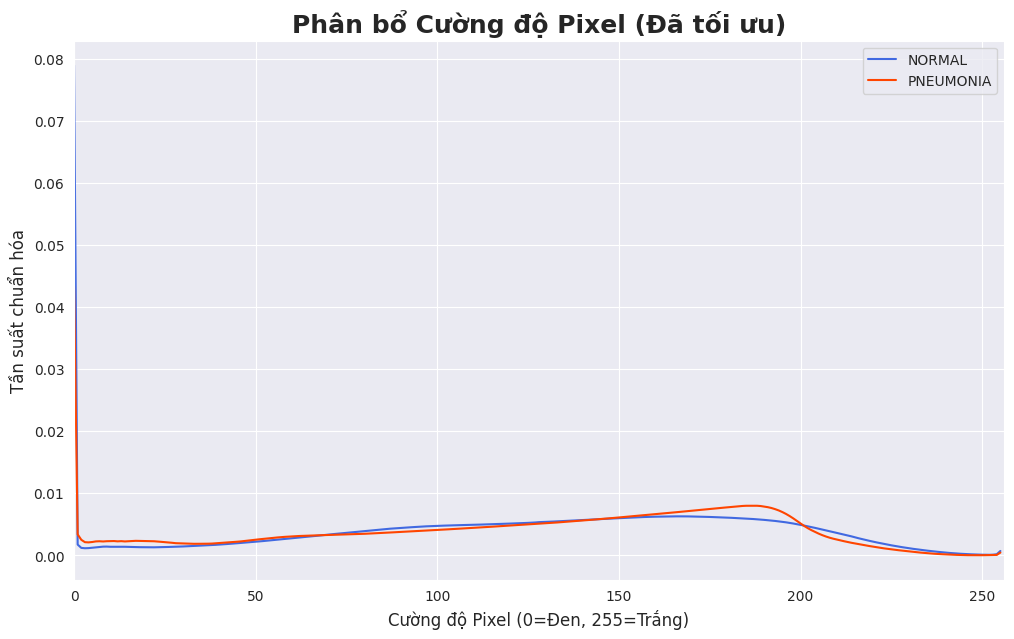

In [8]:
# @title Bước 4.4 (Tối ưu 3: Tính Histogram Tích lũy - Khuyến khích)

import cv2
import numpy as np

def plot_pixel_intensity_distribution_optimized(base_dir):
    """Vẽ biểu đồ histogram bằng cách tính toán tích lũy, cực kỳ tiết kiệm RAM."""

    sns.set_style("darkgrid")
    plt.figure(figsize=(12, 7))
    colors = {"NORMAL": "royalblue", "PNEUMONIA": "orangered"}

    for class_name in ['NORMAL', 'PNEUMONIA']:
        class_dir = os.path.join(base_dir, class_name)
        sample_images = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir)]

        # --- THAY ĐỔI CỐT LÕI NẰM Ở ĐÂY ---

        # 1. Khởi tạo một mảng để chứa histogram tổng
        total_histogram = np.zeros(256) # 256 bins cho các giá trị từ 0-255

        # 2. Lặp qua từng ảnh, tính histogram và cộng dồn
        for img_path in sample_images:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                # Tính histogram cho ảnh hiện tại
                hist = cv2.calcHist([img], [0], None, [256], [0, 256])
                # Cộng dồn vào histogram tổng
                total_histogram += hist.flatten()

        # 3. Chuẩn hóa histogram để có thể so sánh (tổng diện tích dưới đường cong = 1)
        total_histogram /= total_histogram.sum()

        # 4. Vẽ biểu đồ đường từ histogram đã tính toán
        plt.plot(total_histogram, color=colors[class_name], label=class_name)

    plt.title('Phân bổ Cường độ Pixel (Đã tối ưu)', fontsize=18, weight='bold')
    plt.xlabel('Cường độ Pixel (0=Đen, 255=Trắng)', fontsize=12)
    plt.ylabel('Tần suất chuẩn hóa', fontsize=12)
    plt.legend()
    plt.xlim([0, 256])
    plt.show()

# Gọi hàm
plot_pixel_intensity_distribution_optimized(train_dir)

In [9]:
# @title Bước 5: Xây dựng mô hình DenseNet121

# Tải mô hình DenseNet121 đã được huấn luyện trước
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

# Đóng băng các trọng số của mô hình gốc
base_model.trainable = False

# Xây dựng các lớp phân loại tùy chỉnh
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Kết hợp thành mô hình cuối cùng
pneumonia_model = Model(inputs=base_model.input, outputs=predictions)

# Biên dịch mô hình
pneumonia_model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# In ra kiến trúc của mô hình
pneumonia_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 156, 156,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 38, 38,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 38, 38,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 38, 38,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 38, 38,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 38, 38,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 38, 38,    │     12,288 │ conv2_block2_0_r

 Total params: 7,300,161 (27.85 MB)

 Trainable params: 262,657 (1.00 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [10]:
# @title Bước 6: Huấn luyện mô hình (Sử dụng Class Weight)

from sklearn.utils import class_weight
import numpy as np
import time

# --- Bắt đầu phần code thêm vào ---

# Tính toán trọng số cho các lớp để xử lý dữ liệu mất cân bằng.
# Lớp nào có ít mẫu hơn sẽ có trọng số cao hơn trong hàm loss.
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
# Tạo một dictionary để truyền vào hàm fit
class_weights = dict(zip(np.unique(train_generator.classes), weights))

print("Các trọng số lớp được tính toán để xử lý mất cân bằng:")
print(class_weights)
print("-" * 50)

# --- Kết thúc phần code thêm vào ---

print("Bắt đầu quá trình huấn luyện...")

# Ghi lại thời gian bắt đầu
start_time = time.time()

# Huấn luyện mô hình với tham số class_weight
history = pneumonia_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    class_weight=class_weights
)

# Ghi lại thời gian kết thúc và tính toán thời gian huấn luyện
end_time = time.time()
training_duration = end_time - start_time

# Chuyển đổi sang định dạng phút và giây để dễ đọc hơn
mins = int(training_duration // 60)
secs = int(training_duration % 60)

print("\nHoàn tất huấn luyện!")
print("-" * 50)
print(f"Tổng thời gian huấn luyện: {mins} phút {secs} giây ({training_duration:.2f} giây)")
print("-" * 50)

Các trọng số lớp được tính toán để xử lý mất cân bằng:
{np.int32(0): np.float64(1.9448173005219984), np.int32(1): np.float64(0.6730322580645162)}
--------------------------------------------------
Bắt đầu quá trình huấn luyện...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 127s 609ms/step - accuracy: 0.7843 - loss: 0.4921 - val_accuracy: 0.9375 - val_loss: 0.2230
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 463ms/step - accuracy: 0.8707 - loss: 0.3023 - val_accuracy: 0.9375 - val_loss: 0.2037
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 449ms/step - accuracy: 0.8823 - loss: 0.2928 - val_accuracy: 0.8750 - val_loss: 0.2555
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.8822 - loss: 0.2814 - val_accuracy: 0.9375 - val_loss: 0.2387
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.8934 - loss: 0.2487 - val_accuracy: 0.8750 - val_loss: 0.2881
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 464ms/step - accuracy: 0.8930 - loss: 0.2456 - val_accuracy: 0.8750 - val_loss: 0.2357
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 73s 446ms/step - accuracy: 0.8893 - loss: 0.2631 - val_accuracy: 0.8750 - val_loss: 0.2347
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 438ms/step - accuracy: 0.9034 - loss: 

In [11]:
# @title Bước 6.9: Lưu trữ mô hình đã huấn luyện

import os

print("Bắt đầu quá trình lưu mô hình...")

# Tạo đường dẫn và tên file để lưu
# Chúng ta sẽ lưu vào một thư mục 'saved_models' trên Google Drive để cho gọn gàng
save_dir = '/content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/saved_models/'
model_filename = 'pneumonia_densenet121_model.h5'
model_save_path = os.path.join(save_dir, model_filename)

# Kiểm tra xem thư mục có tồn tại không, nếu không thì tạo mới
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    print(f"Đã tạo thư mục mới tại: {save_dir}")

# Sử dụng hàm save() của Keras để lưu mô hình
# Định dạng .h5 sẽ lưu tất cả mọi thứ: kiến trúc, trọng số, và trạng thái optimizer.
pneumonia_model.save(model_save_path)

print("-" * 50)
print(f"Lưu mô hình thành công!")
print(f"Đường dẫn: {model_save_path}")
print("-" * 50)

Bắt đầu quá trình lưu mô hình...
--------------------------------------------------
Lưu mô hình thành công!
Đường dẫn: /content/drive/MyDrive/Đồ án chuyên ngành Trí tuệ nhân tạo/saved_models/pneumonia_densenet121_model.h5
--------------------------------------------------


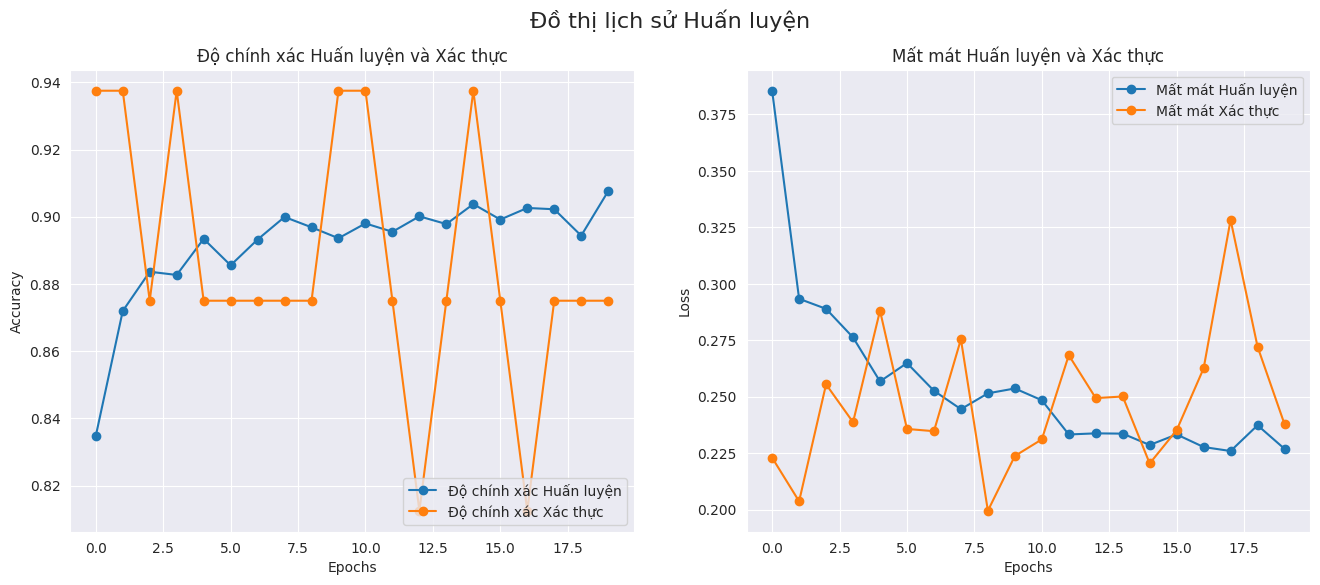

In [ ]:
# @title Bước 7: Đánh giá và Trực quan hóa kết quả

# 1. Hàm để vẽ đồ thị lịch sử huấn luyện
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, 'o-', label='Độ chính xác Huấn luyện')
    plt.plot(epochs_range, val_acc, 'o-', label='Độ chính xác Xác thực')
    plt.legend(loc='lower right')
    plt.title('Độ chính xác Huấn luyện và Xác thực')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, 'o-', label='Mất mát Huấn luyện')
    plt.plot(epochs_range, val_loss, 'o-', label='Mất mát Xác thực')
    plt.legend(loc='upper right')
    plt.title('Mất mát Huấn luyện và Xác thực')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.suptitle('Đồ thị lịch sử Huấn luyện', fontsize=16)
    plt.show()

# 2. Vẽ đồ thị
plot_training_history(history)

In [13]:
# 3. Đánh giá trên tập dữ liệu kiểm tra
print("\nĐánh giá trên tập dữ liệu kiểm tra...")
test_loss, test_accuracy = pneumonia_model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)
print("-" * 50)
print(f"Độ mất mát trên tập kiểm tra (Test Loss): {test_loss:.4f}")
print(f"Độ chính xác trên tập kiểm tra (Test Accuracy): {test_accuracy*100:.2f}%")
print("-" * 50)


Đánh giá trên tập dữ liệu kiểm tra...
19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 197ms/step - accuracy: 0.8923 - loss: 0.2614
--------------------------------------------------
Độ mất mát trên tập kiểm tra (Test Loss): 0.2891
Độ chính xác trên tập kiểm tra (Test Accuracy): 87.99%
--------------------------------------------------


In [14]:
# @title Bước 8: Đánh giá chi tiết (Precision, Recall, F1-Score)

from sklearn.metrics import classification_report
import numpy as np

print("Đang tạo báo cáo phân loại chi tiết...")

# Lấy các nhãn dự đoán từ mô hình trên tập test
steps_for_prediction = int(np.ceil(test_generator.samples / BATCH_SIZE))
y_pred_probs = pneumonia_model.predict(test_generator, steps=steps_for_prediction)

# Chuyển xác suất thành nhãn 0 hoặc 1
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Lấy các nhãn thực tế từ trình tạo dữ liệu
# Đảm bảo chúng ta chỉ lấy đúng số lượng nhãn tương ứng với số dự đoán
y_true = test_generator.classes[:len(y_pred)]

# Lấy tên của các lớp
target_names = list(test_generator.class_indices.keys())

# Tạo và in báo cáo
report = classification_report(y_true, y_pred, target_names=target_names)

print("\nBáo cáo phân loại (Classification Report):")
print(report)

Đang tạo báo cáo phân loại chi tiết...
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 877ms/step

Báo cáo phân loại (Classification Report):
              precision    recall  f1-score   support

      NORMAL       0.82      0.88      0.85       234
   PNEUMONIA       0.92      0.88      0.90       390

    accuracy                           0.88       624
   macro avg       0.87      0.88      0.88       624
weighted avg       0.89      0.88      0.88       624



Đang tạo ma trận nhầm lẫn...


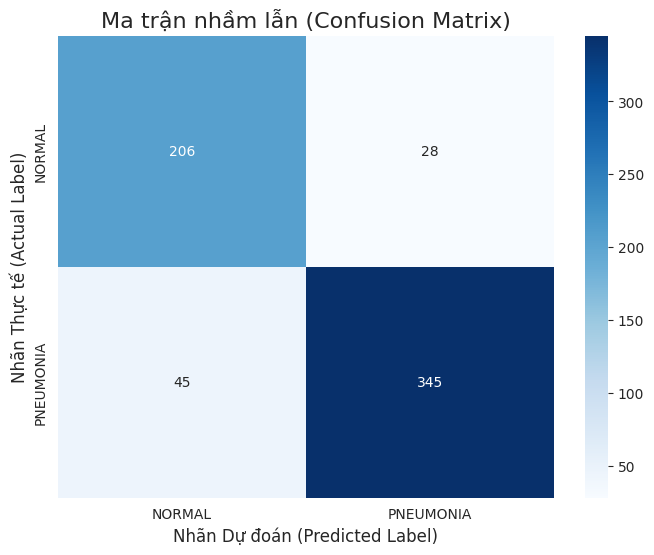

In [15]:
# @title Bước 9: Trực quan hóa Ma trận nhầm lẫn (Confusion Matrix)

from sklearn.metrics import confusion_matrix
import seaborn as sns

print("Đang tạo ma trận nhầm lẫn...")

# Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

# Lấy tên của các lớp
class_names = list(test_generator.class_indices.keys())

# Vẽ ma trận bằng seaborn heatmap để đẹp hơn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title('Ma trận nhầm lẫn (Confusion Matrix)', fontsize=16)
plt.ylabel('Nhãn Thực tế (Actual Label)', fontsize=12)
plt.xlabel('Nhãn Dự đoán (Predicted Label)', fontsize=12)
plt.show()

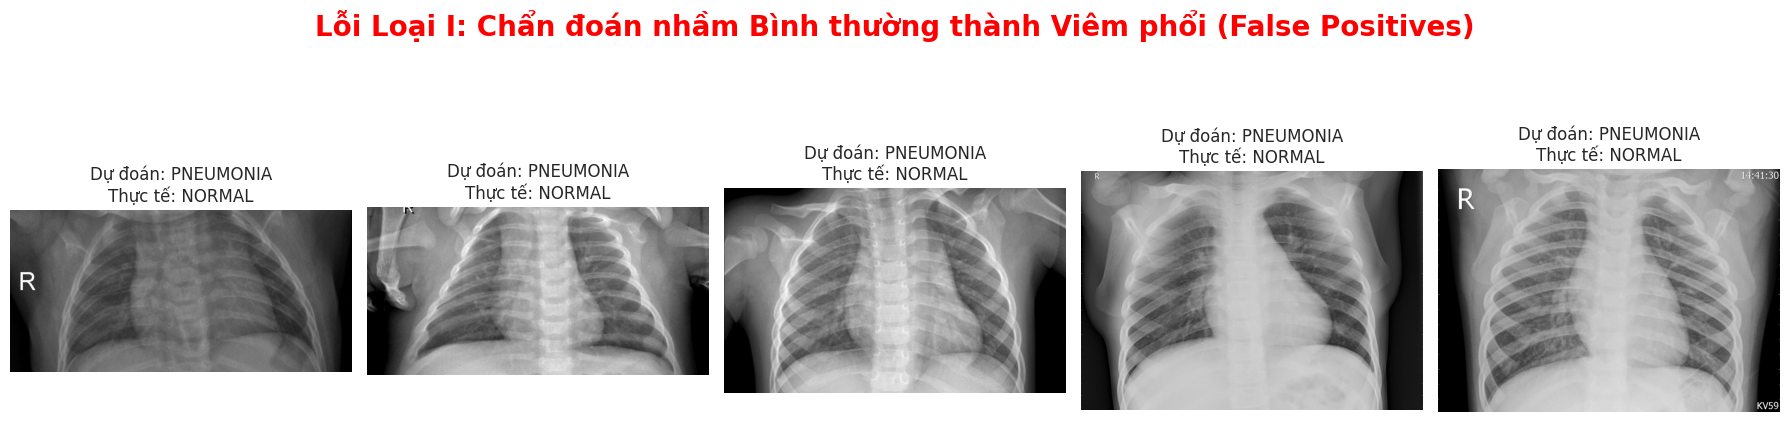

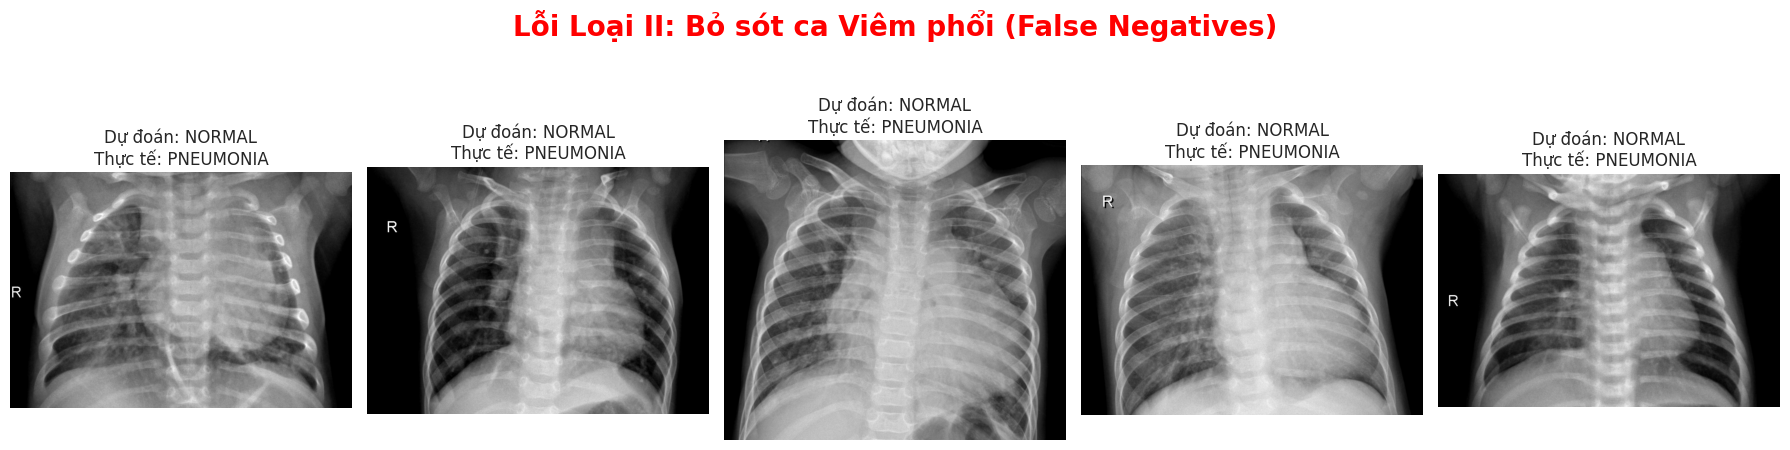

In [16]:
# @title Bước 9.1: Trực quan hóa các ca dự đoán sai

# Tìm chỉ số của các ca dự đoán sai
error_indices = np.where(y_pred != y_true)[0]
filenames = test_generator.filenames

# Phân loại các lỗi
false_positives = [i for i in error_indices if y_true[i] == 0 and y_pred[i] == 1]
false_negatives = [i for i in error_indices if y_true[i] == 1 and y_pred[i] == 0]

def plot_error_images(indices, title, num_samples=5):
    """Vẽ các hình ảnh mà mô hình đã dự đoán sai."""
    if not indices:
        print(f"Không có ca '{title}' nào để hiển thị. Mô hình hoàn hảo!")
        return

    sns.set_style("white")
    plt.figure(figsize=(18, 5))
    plt.suptitle(title, fontsize=20, color='red', weight='bold')

    for i, idx in enumerate(indices[:num_samples]):
        plt.subplot(1, num_samples, i + 1)
        img_path = os.path.join(test_dir, filenames[idx])
        img = mpimg.imread(img_path)
        plt.imshow(img, cmap='gray')

        predicted_label = "PNEUMONIA" if y_pred[idx] == 1 else "NORMAL"
        actual_label = "PNEUMONIA" if y_true[idx] == 1 else "NORMAL"

        plt.title(f"Dự đoán: {predicted_label}\nThực tế: {actual_label}", fontsize=12)
        plt.axis('off')
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Hiển thị các lỗi
plot_error_images(false_positives, "Lỗi Loại I: Chẩn đoán nhầm Bình thường thành Viêm phổi (False Positives)")
plot_error_images(false_negatives, "Lỗi Loại II: Bỏ sót ca Viêm phổi (False Negatives)")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


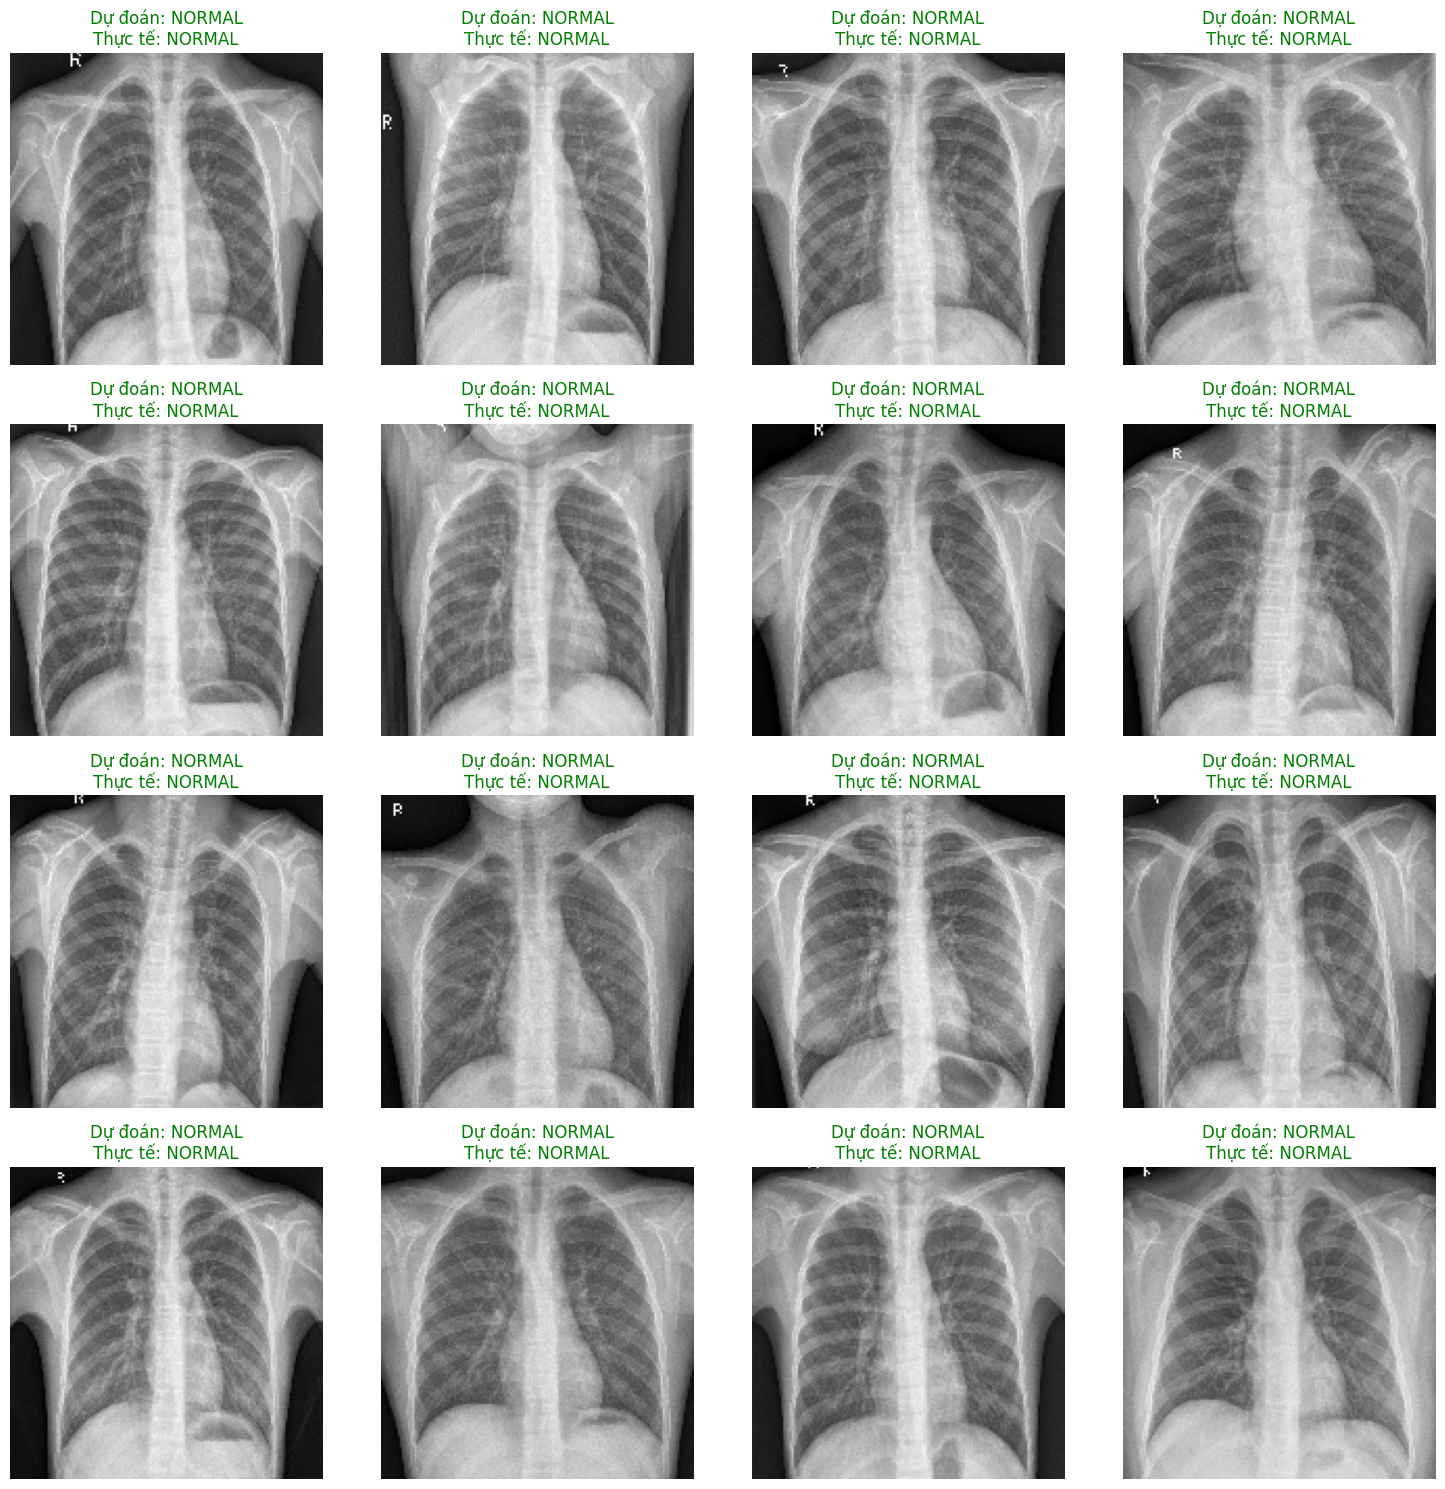

In [17]:
# @title Bước 10: Xem kết quả dự đoán trên ảnh thực tế

# Lấy một lô (batch) ảnh và nhãn từ tập test
x_test_batch, y_test_batch = next(test_generator)

# Lấy dự đoán cho lô ảnh này
y_pred_batch_probs = pneumonia_model.predict(x_test_batch)
y_pred_batch = (y_pred_batch_probs > 0.5).astype("int32").flatten()

# Lấy nhãn thực tế của lô
y_true_batch = y_test_batch.astype("int32")

# Tạo một bản đồ từ chỉ số lớp sang tên lớp
label_map = {v: k for k, v in train_generator.class_indices.items()}

# Hiển thị 16 ảnh đầu tiên trong lô
plt.figure(figsize=(15, 15))
for i in range(min(16, len(x_test_batch))):
    plt.subplot(4, 4, i + 1)
    # Ảnh đã được rescale về [0,1] nên có thể hiển thị trực tiếp
    plt.imshow(x_test_batch[i])

    predicted_label = label_map[y_pred_batch[i]]
    true_label = label_map[y_true_batch[i]]

    # Đặt màu cho tiêu đề dựa trên kết quả đúng/sai
    if predicted_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title(f"Dự đoán: {predicted_label}\nThực tế: {true_label}", color=color)
    plt.axis('off')

plt.tight_layout()
plt.show()

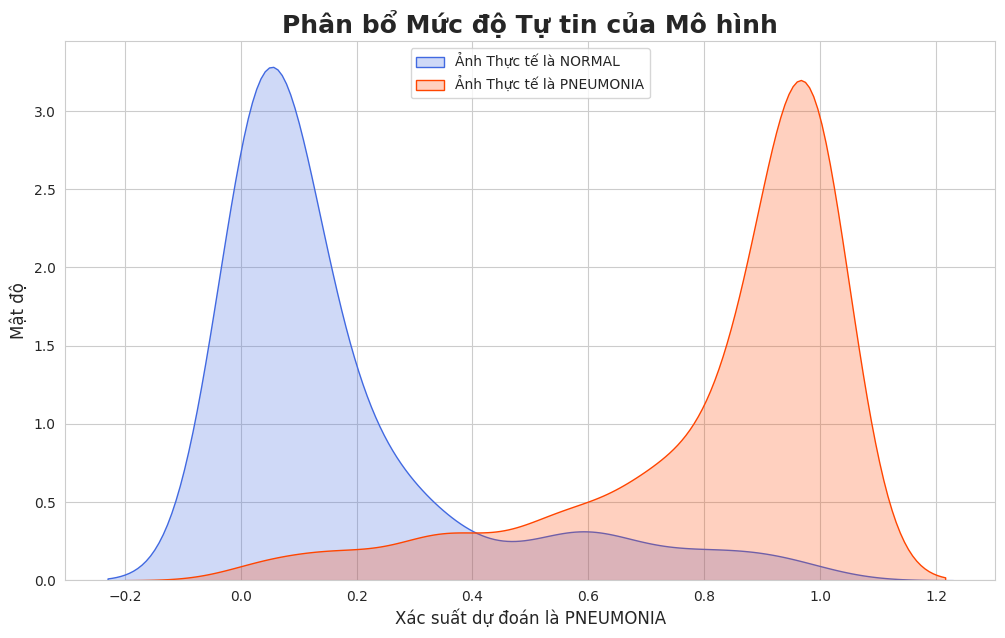

In [18]:
# @title Bước 13: Phân bổ Xác suất Dự đoán

def plot_prediction_probabilities(y_true, y_pred_probs):
    """Vẽ biểu đồ phân bổ xác suất dự đoán cho mỗi lớp thực tế."""

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7))

    # Tách xác suất dựa trên nhãn thực tế
    probs_normal = y_pred_probs[y_true == 0]
    probs_pneumonia = y_pred_probs[y_true == 1]

    # Vẽ biểu đồ mật độ (KDE)
    sns.kdeplot(probs_normal, fill=True, color="royalblue", label="Ảnh Thực tế là NORMAL")
    sns.kdeplot(probs_pneumonia, fill=True, color="orangered", label="Ảnh Thực tế là PNEUMONIA")

    plt.title('Phân bổ Mức độ Tự tin của Mô hình', fontsize=18, weight='bold')
    plt.xlabel('Xác suất dự đoán là PNEUMONIA', fontsize=12)
    plt.ylabel('Mật độ', fontsize=12)
    plt.legend()
    plt.show()

# Gọi hàm để vẽ
plot_prediction_probabilities(y_true, y_pred_probs.flatten())

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 150, 150, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step


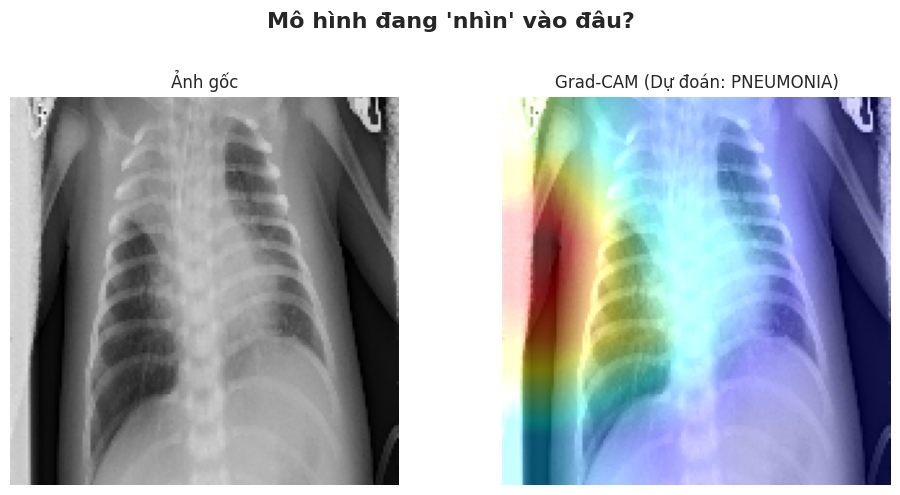

In [19]:
# @title Bước 14 (Nâng cao): Diễn giải Mô hình với Grad-CAM

from tensorflow.keras.models import Model
import tensorflow as tf
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """Tạo ra một bản đồ nhiệt Grad-CAM."""
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='conv5_block16_2_conv'):
    """Hiển thị ảnh gốc và ảnh với bản đồ nhiệt Grad-CAM."""

    # Chuẩn bị ảnh
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT), color_mode='rgb')
    img_array = image.img_to_array(img)
    img_array_normalized = img_array / 255.0
    img_batch = np.expand_dims(img_array_normalized, axis=0)

    # Tạo bản đồ nhiệt
    heatmap = make_gradcam_heatmap(img_batch, model, last_conv_layer_name)

    # Tải lại ảnh gốc để chồng lớp
    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (IMG_WIDTH, IMG_HEIGHT))

    # Chồng lớp bản đồ nhiệt lên ảnh gốc
    heatmap_resized = cv2.resize(heatmap, (IMG_WIDTH, IMG_HEIGHT))
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    superimposed_img = heatmap_colored * 0.4 + original_img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

    # Dự đoán
    prob = model.predict(img_batch)[0][0]
    prediction = "PNEUMONIA" if prob > 0.5 else "NORMAL"

    # Hiển thị
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Ảnh gốc")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title(f"Grad-CAM (Dự đoán: {prediction})")
    plt.axis('off')

    plt.suptitle("Mô hình đang 'nhìn' vào đâu?", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

# Lấy một ảnh viêm phổi từ tập test để minh họa
sample_pneumonia_path = os.path.join(test_dir, 'PNEUMONIA', os.listdir(os.path.join(test_dir, 'PNEUMONIA'))[5])

# Tên lớp conv cuối cùng của DenseNet121 là 'conv5_block16_2_conv'
# Bạn có thể tìm thấy tên này bằng cách chạy model.summary()
display_gradcam(sample_pneumonia_path, pneumonia_model, 'conv5_block16_2_conv')